# Similarity and Distance Measures

```yaml
Course:   DS 5001
Module:   06 Homework
Author:   Andrew Avitabile
Date:     21 February 2024 
```

# Set Up

## Config

In [1]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_hone = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']

In [2]:
data_prefix = 'austen-melville'
OHCO = ['book_id', 'chap_id']
bag = 'CHAPS'
colors = "YlGnBu"
tf_agg = 'sum'
CHAPS = OHCO[:2]
BOOKS = OHCO[:1]

## Import Packages

In [3]:
import pandas as pd
import numpy as np
import plotly_express as px
import seaborn as sns; sns.set()
from numpy.linalg import norm
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Prepare the Data

## Import tables

In [4]:
CORPUS = pd.read_csv(f"{output_dir}/{data_prefix}-CORPUS.csv") #Import Austen-Melville corpus, with OHCO as the index
LIB = pd.read_csv(f'{output_dir}/{data_prefix}-LIB.csv').set_index('book_id') #Import Austen-Melville lib, with book_id as the index

## Create a label for each book

In [5]:
austen_years = {
    'book_id': [158, 946, 1212, 141, 121, 105, 1342, 161],
    'year': [1815, 1794, 1790, 1814, 1803, 1818, 1813, 1811],
    'title': ['Emma', 'Lady Susan', 'Love And Freindship And Other Early Works', 'Mansfield Park', 'Northanger Abbey', 'Persuasion', 'Pride and Prejudice', 'Sense and Sensibility'],
    'author': ['AUSTEN, JANE', 'AUSTEN, JANE', 'AUSTEN, JANE', 'AUSTEN, JANE', 'AUSTEN, JANE', 'AUSTEN, JANE', 'AUSTEN, JANE', 'AUSTEN, JANE'] 
}

austen_years = pd.DataFrame(austen_years)

austen_years['label'] = austen_years['title'] + ', ' + austen_years['year'].astype(str)

austen_years = austen_years.loc[:, ['book_id', 'author', 'label']]

## Subset to just Austen

In [6]:
# Create Austen-only lib
austen_LIB = LIB[LIB['author'] == 'AUSTEN, JANE']
austen_LIB = austen_LIB.merge(austen_years, on=['book_id', 'author'], how='left').set_index('book_id')

In [7]:
# Create Austen-only corpus
CORPUS_w_author = CORPUS.merge(austen_years, on='book_id', how='left')
austen_CORPUS = CORPUS_w_author[CORPUS_w_author['author'] == 'AUSTEN, JANE']

In [8]:
# Create Austen-only vocab
austen_VOCAB = austen_CORPUS.term_str.value_counts().to_frame('n')
austen_VOCAB.index.name = 'term_str'
austen_VOCAB['p'] = austen_VOCAB.n / austen_VOCAB.n.sum()
austen_VOCAB['i'] = np.log2(1/austen_VOCAB.p)
austen_VOCAB['max_pos'] = austen_CORPUS.reset_index().value_counts(['term_str','pos']).sort_index().unstack().idxmax(1)

## Create functions to get BOW and TFIDF

In [9]:
def create_bow(CORPUS, bag, item_type='term_str'):
    BOW = CORPUS.groupby(bag+[item_type])[item_type].count().to_frame('n')
    return BOW

In [10]:
def get_tfidf(BOW, tf_method='max', df_method='standard', item_type='term_str'):
            
    DTCM = BOW.n.unstack(fill_value=0) # Create Doc-Term Count Matrix
    
    if tf_method == 'sum':
        TF = (DTCM.T / DTCM.T.sum()).T
    elif tf_method == 'max':
        TF = (DTCM.T / DTCM.T.max()).T
    elif tf_method == 'log':
        TF = (np.log2(1 + DTCM.T)).T
    elif tf_method == 'raw':
        TF = DTCM
    elif tf_method == 'bool':
        TF = DTCM.astype('bool').astype('int')
    else:
        raise ValueError(f"TF method {tf_method} not found.")

    DF = DTCM.astype('bool').sum()
    N_docs = len(DTCM)
    
    if df_method == 'standard':
        IDF = np.log2(N_docs/DF) # This what the students were asked to use
    elif df_method == 'textbook':
        IDF = np.log2(N_docs/(DF + 1))
    elif df_method == 'sklearn':
        IDF = np.log2(N_docs/DF) + 1
    elif df_method == 'sklearn_smooth':
        IDF = np.log2((N_docs + 1)/(DF + 1)) + 1
    else:
        raise ValueError(f"DF method {df_method} not found.")
    
    TFIDF = TF * IDF

    return TFIDF

In [11]:
# Create BOW, with Chapters as the bag
BOW_chaps = create_bow(austen_CORPUS, bag=CHAPS)

In [12]:
# Create TFIDF, using max tf_method and standard df_method
TFIDF_chaps = get_tfidf(BOW_chaps, tf_method='max', df_method='standard')
TFIDF_chaps

term_str           0         1   10  10000  10th  11th   12  12th  1399  13th  \
book_id chap_id                                                                 
105     1        0.0  0.119092  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        2        0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        3        0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        4        0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        5        0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
...              ...       ...  ...    ...   ...   ...  ...   ...   ...   ...   
1342    57       0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        58       0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        59       0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        60       0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   
        61       0.0  0.000000  0.0    0.0   0.0   0.0  0.0   0.0   0.0   0.0   

term_str         ...  youthful  youths  yrs         z      zeal   zealous  \
book_id chap_id  ...                                                        
105     1        ...  0.043417     0.0  0.0  0.067611  0.000000  0.000000   
        2        ...  0.000000     0.0  0.0  0.000000  0.000000  0.061689   
        3        ...  0.000000     0.0  0.0  0.000000  0.036998  0.000000   
        4        ...  0.000000     0.0  0.0  0.000000  0.000000  0.000000   
        5        ...  0.000000     0.0  0.0  0.000000  0.000000  0.000000   
...              ...       ...     ...  ...       ...       ...       ...   
1342    57       ...  0.000000     0.0  0.0  0.000000  0.000000  0.000000   
        58       ...  0.000000     0.0  0.0  0.000000  0.000000  0.000000   
        59       ...  0.000000     0.0  0.0  0.000000  0.000000  0.000000   
        60       ...  0.000000     0.0  0.0  0.000000  0.000000  0.000000   
        61       ...  0.000000     0.0  0.0  0.000000  0.000000  0.000000   

term_str         zealously  zephyr  zigzags  ł20000  
book_id chap_id                                      
105     1              0.0     0.0      0.0     0.0  
        2              0.0     0.0      0.0     0.0  
        3              0.0     0.0      0.0     0.0  
        4              0.0     0.0      0.0     0.0  
        5              0.0     0.0      0.0     0.0  
...                    ...     ...      ...     ...  
1342    57             0.0     0.0      0.0     0.0  
        58             0.0     0.0      0.0     0.0  
        59             0.0     0.0      0.0     0.0  
        60             0.0     0.0      0.0     0.0  
        61             0.0     0.0      0.0     0.0  

[334 rows x 14745 columns]

# Calculate mean TFIDF of open POS

In [13]:
TFIDF = TFIDF_chaps.groupby(OHCO[:1]).mean()
TFIDF

term_str,0,1,10,10000,10th,11th,12,12th,1399,13th,...,youthful,youths,yrs,z,zeal,zealous,zealously,zephyr,zigzags,ł20000
book_id,,,,,,,,,,,,,,,,,,,,,
105,0.000000,0.004962,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.001809,0.00000,0.000000,0.002817,0.005670,0.004309,0.002501,0.000000,0.00000,0.000000
121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.002806,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
141,0.000000,0.000000,0.003480,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.00000,0.000000,0.000000,0.004031,0.000755,0.000000,0.000000,0.00000,0.000981
158,0.000000,0.000000,0.000000,0.004234,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.001783,0.00000,0.000000,0.000000,0.002909,0.000000,0.000000,0.000000,0.00121,0.000000
161,0.000000,0.001522,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.003153,0.00000,0.000000,0.000000,0.001602,0.002279,0.002786,0.000000,0.00000,0.000000
946,0.000000,0.000000,0.004482,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.007724,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
1212,0.001968,0.000000,0.000000,0.000000,0.009915,0.000984,0.006986,0.000984,0.001359,0.00293,...,0.000000,0.00000,0.021491,0.000000,0.000000,0.001880,0.000000,0.000984,0.00000,0.000000
1342,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.00151,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


In [14]:
#Calculate the mean tfidf
mean_TFIDF = TFIDF.mean().to_frame('mean_tfidf').join(austen_VOCAB.max_pos, how = "inner") 

#Limit to just desired POS tags
desired_pos_tags = ['NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']

#Keep just the 1000 most significant terms
mean_TFIDF_lim = mean_TFIDF[mean_TFIDF['max_pos'].isin(desired_pos_tags)].sort_values(by='mean_tfidf', ascending=False).head(1000)

mean_TFIDF_lim2 = mean_TFIDF_lim.loc[:, ['max_pos']]

In [15]:
# "Collapse" TFIDF matrix so that it contains mean TFIDF of each term by book. This will result in a matrix with book IDs as rows, and significant terms as columns.
mean_TFIDF_by_book = TFIDF.groupby('book_id').mean().stack().sort_values(ascending=False).to_frame('mean_tfidf')

# Limit to just those top 1000 words
mean_TFIDF_by_book = mean_TFIDF_by_book.join(mean_TFIDF_lim2, how = "inner")

In [16]:
# Use pivot to transform the DataFrame
mean_TFIDF_by_book_wide = mean_TFIDF_by_book.reset_index()

mean_TFIDF_by_book_wide = mean_TFIDF_by_book_wide.pivot(index='book_id', columns='term_str', values='mean_tfidf')

# Reset the index if you want 'book_id' as a column instead of an index
mean_TFIDF_by_book_wide.reset_index(inplace=True)

# If you want to remove the name of the columns and the index name
mean_TFIDF_by_book_wide.columns.name = None
mean_TFIDF_by_book_wide.index.name = None

mean_TFIDF_by_book_wide = mean_TFIDF_by_book_wide.set_index('book_id')
mean_TFIDF_by_book_wide

,abilities,able,absence,absolutely,accept,account,acquaintance,acquainted,act,acting,...,wrote,year,years,yes,yesterday,yet,young,younger,yours,youth
book_id,,,,,,,,,,,,,,,,,,,,,
105,0.005400,0.007063,0.004201,0.003214,0.004572,0.009493,0.019410,0.013924,0.004974,0.004616,...,0.002818,0.011354,0.021086,0.010142,0.009706,0.008263,0.010037,0.006217,0.006201,0.014419
121,0.004188,0.008429,0.010450,0.001819,0.001318,0.009531,0.017537,0.005929,0.002273,0.003380,...,0.000698,0.006563,0.011367,0.019185,0.003479,0.008611,0.014850,0.005773,0.007926,0.004474
141,0.002632,0.008697,0.010947,0.008565,0.007065,0.007739,0.006527,0.003138,0.018340,0.018411,...,0.007317,0.011601,0.011221,0.014118,0.005551,0.008660,0.009665,0.005520,0.005620,0.002779
158,0.001636,0.011177,0.006547,0.011217,0.005475,0.009684,0.011272,0.009450,0.006855,0.003746,...,0.009225,0.007745,0.013004,0.017290,0.009982,0.009527,0.012815,0.001067,0.001932,0.006102
161,0.007546,0.007654,0.005259,0.004046,0.005774,0.008991,0.013762,0.010964,0.005631,0.003942,...,0.006506,0.017544,0.014594,0.011022,0.006846,0.008320,0.008929,0.004386,0.005463,0.004007
946,0.020959,0.009830,0.005737,0.012270,0.008060,0.016031,0.003857,0.015176,0.020418,0.004017,...,0.006179,0.000753,0.010577,0.000000,0.015026,0.010723,0.009188,0.002618,0.046576,0.003555
1212,0.000392,0.006946,0.004946,0.000234,0.007987,0.005157,0.010702,0.011047,0.011732,0.005217,...,0.002540,0.008430,0.019947,0.007384,0.005747,0.021363,0.008325,0.005115,0.019138,0.026596
1342,0.003841,0.009329,0.011327,0.007164,0.009829,0.006890,0.010445,0.008634,0.004689,0.001792,...,0.011127,0.009746,0.008549,0.013016,0.005150,0.007310,0.011893,0.017307,0.009408,0.004538


In [17]:
L0 = mean_TFIDF_by_book_wide.astype('bool').astype('int') # Binary (Pseudo L)
L1 = mean_TFIDF_by_book_wide.apply(lambda x: x / x.sum(), 1) # Probabilistic
L2 = mean_TFIDF_by_book_wide.apply(lambda x: x / norm(x), 1) # Pythagorean, AKA Euclidean

## Create Doc Pair Table

Create a table to store our results.

Note that `pist()` is a "distance matrix computation from a collection of raw observation vectors stored in a rectangular array".

In [18]:
# Create dataframe with cartesian product of books by books
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([austen_LIB.index.tolist(), austen_LIB.index.tolist()])).reset_index()

# Keep only unique pairs of different books
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])

# Name index cols
PAIRS.index.names = ['doc_a', 'doc_b']

In [19]:
PAIRS.shape

(28, 0)

In [20]:
PAIRS.head()

Empty DataFrame
Columns: []
Index: [(105, 121), (105, 141), (105, 158), (105, 161), (105, 946)]

## Compute Distances

Now we use `pdist()` to compute a bunch of pairwise distances.

We associate measure types with the right norms.

In [21]:
PAIRS['cityblock'] = pdist(mean_TFIDF_by_book_wide, 'cityblock')
PAIRS['cosine'] = pdist(mean_TFIDF_by_book_wide, 'cosine')
PAIRS['euclidean'] = pdist(L2, 'euclidean')
PAIRS['jaccard'] = pdist(L0, 'jaccard')
PAIRS['js'] = pdist(L1, 'jensenshannon')  

In [22]:
PAIRS.loc[105].style.background_gradient(cmap="seismic", axis=0)

,cityblock,cosine,euclidean,jaccard,js
doc_b,,,,,
121,3.719449,0.188363,0.613781,0.032520,0.243739
141,2.958854,0.128306,0.506569,0.022426,0.200032
158,3.249084,0.135786,0.521126,0.023469,0.203981
161,3.589550,0.163106,0.571149,0.028398,0.226469
946,6.342187,0.450753,0.949477,0.101729,0.390221
1212,7.448245,0.571541,1.069150,0.084848,0.430605
1342,3.682326,0.162112,0.569407,0.019348,0.227078


# Create Clusters

We now use our pair-wise distances between books to apply aggomerative clustering.

We visualize the clustering using a dendrogram. 

## Hiearchical

In [23]:
def hac(sims, linkage_method='complete', color_thresh=.3, figsize=(10, 10)):

    # Generate the clustering
    tree = sch.linkage(sims, method=linkage_method)
    
    # Get labels for the leaves
    labels = austen_LIB.label.values
    
    # Create a figure 
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    
    # Create a dendrogram with the tree
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    
    # Change the appearance of ticks, tick labels, and gridlines
    plt.tick_params(axis='both', which='major', labelsize=14)

<Figure size 640x480 with 0 Axes>

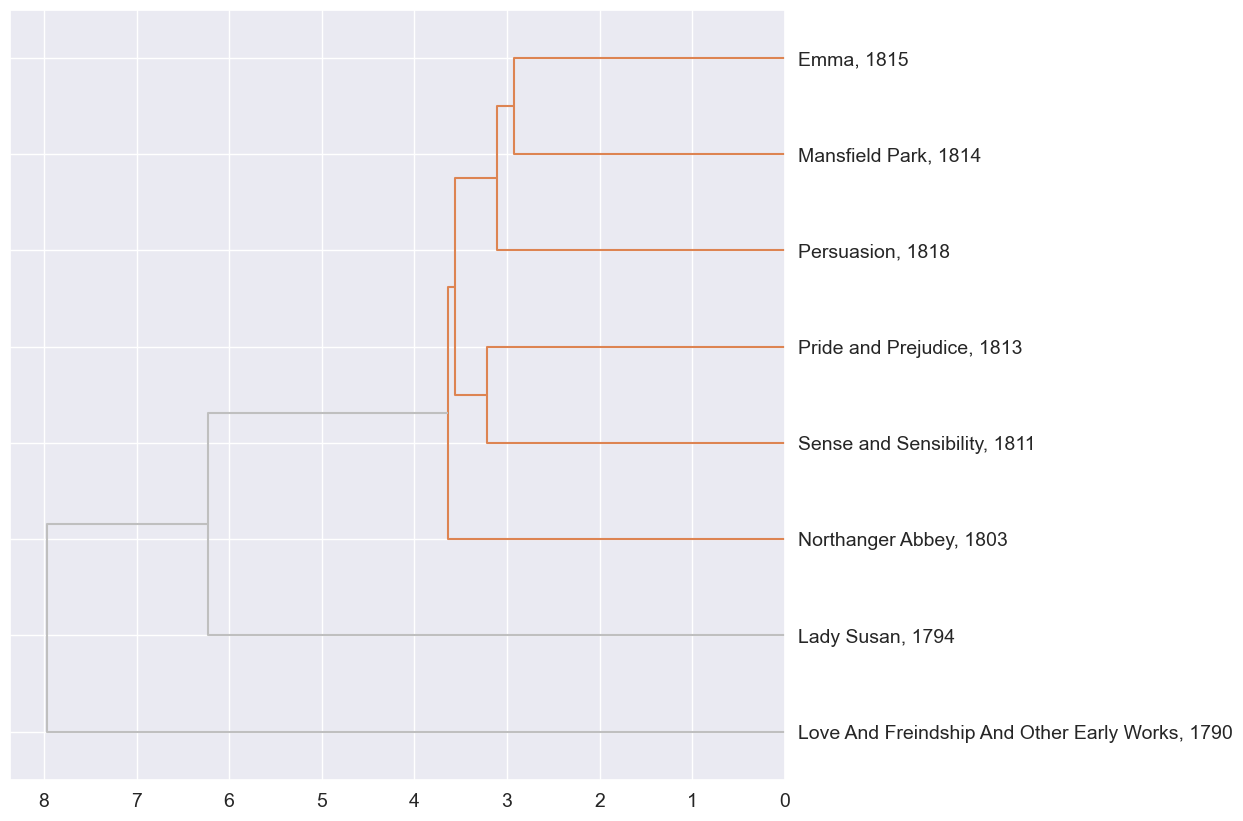

In [24]:
hac(PAIRS.cityblock, linkage_method = "weighted", color_thresh=4);

<Figure size 640x480 with 0 Axes>

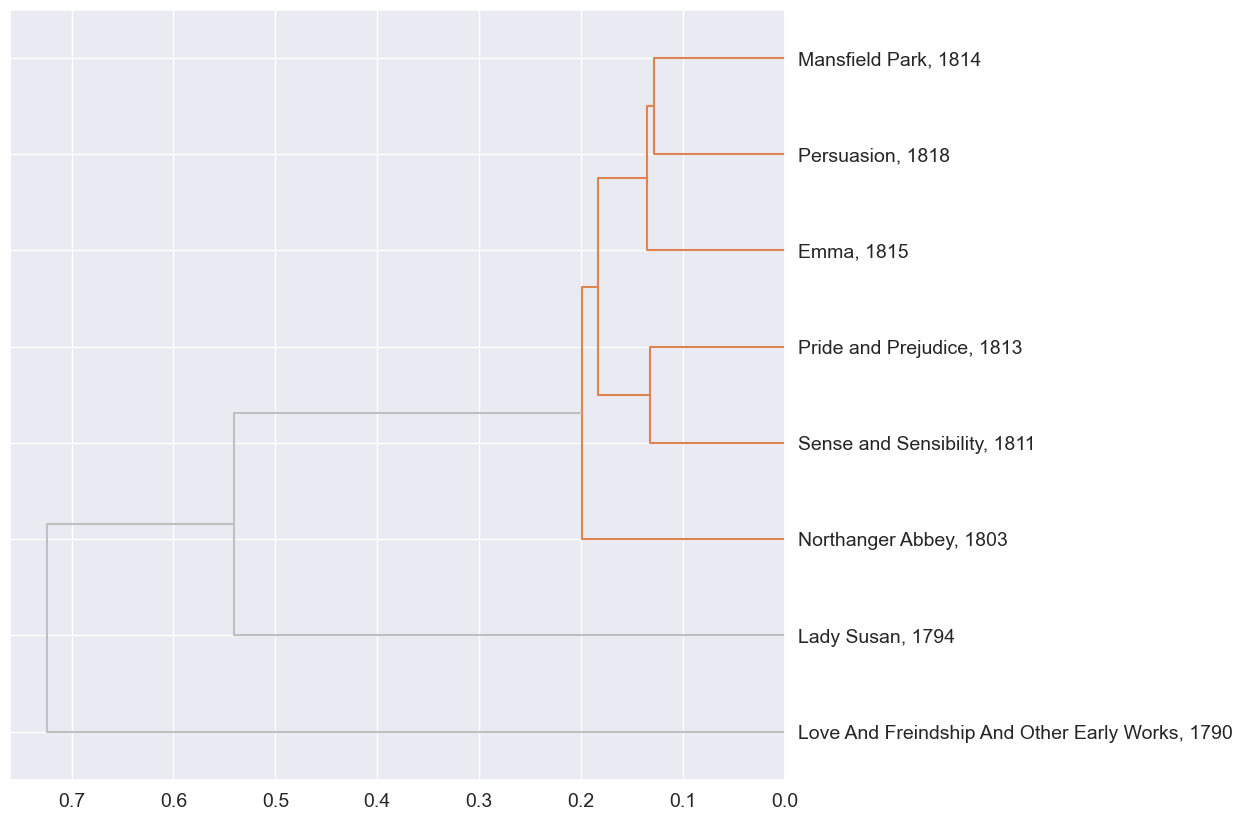

In [25]:
hac(PAIRS.cosine, linkage_method='ward', color_thresh=0.4)

<Figure size 640x480 with 0 Axes>

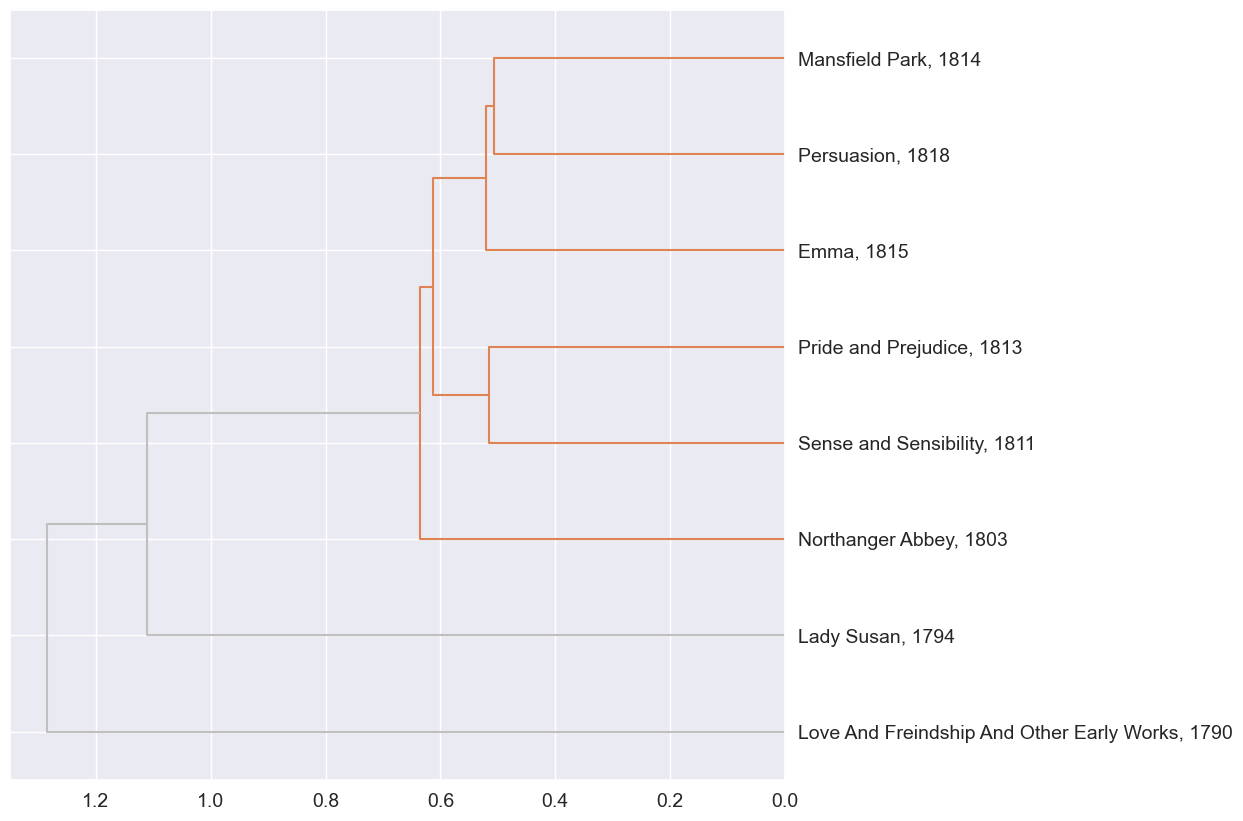

In [26]:
hac(PAIRS.euclidean, linkage_method='ward', color_thresh=1);

<Figure size 640x480 with 0 Axes>

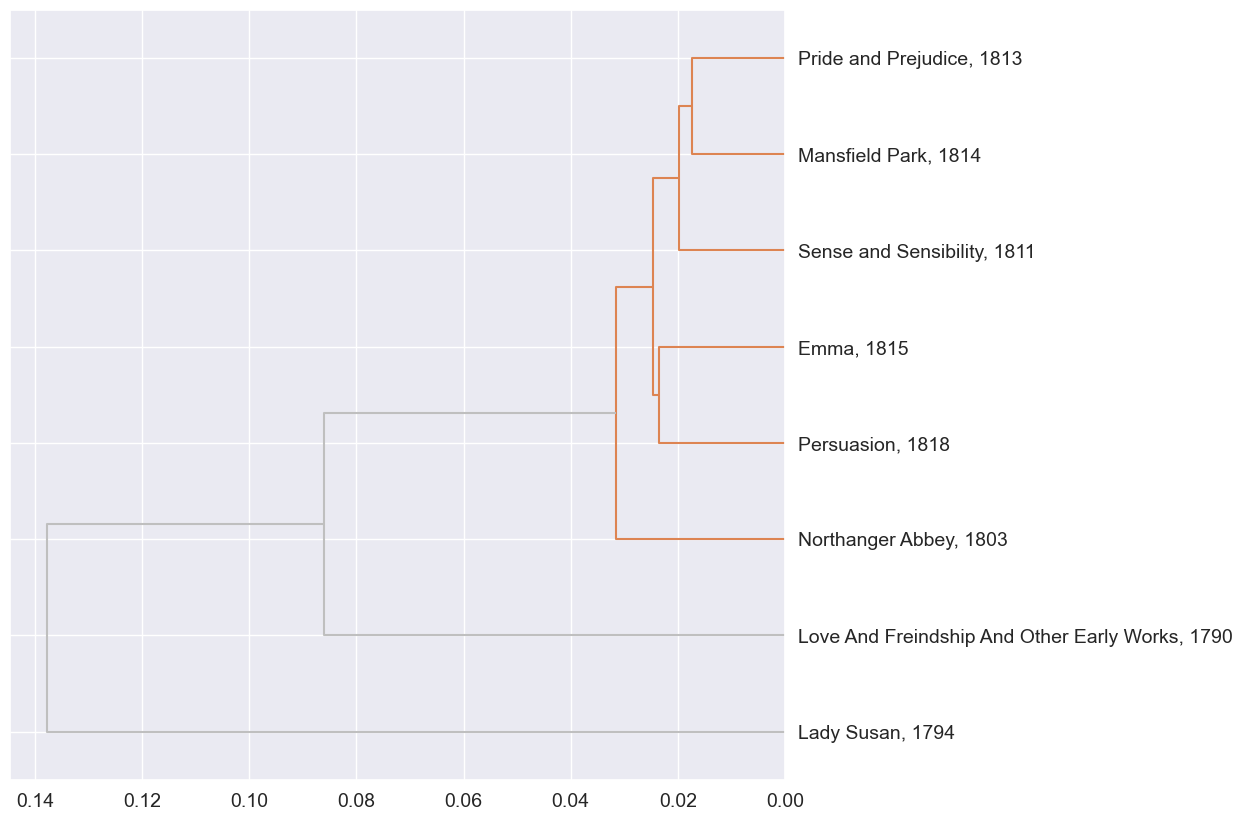

In [27]:
hac(PAIRS.jaccard, linkage_method = "weighted", color_thresh=.08);

<Figure size 640x480 with 0 Axes>

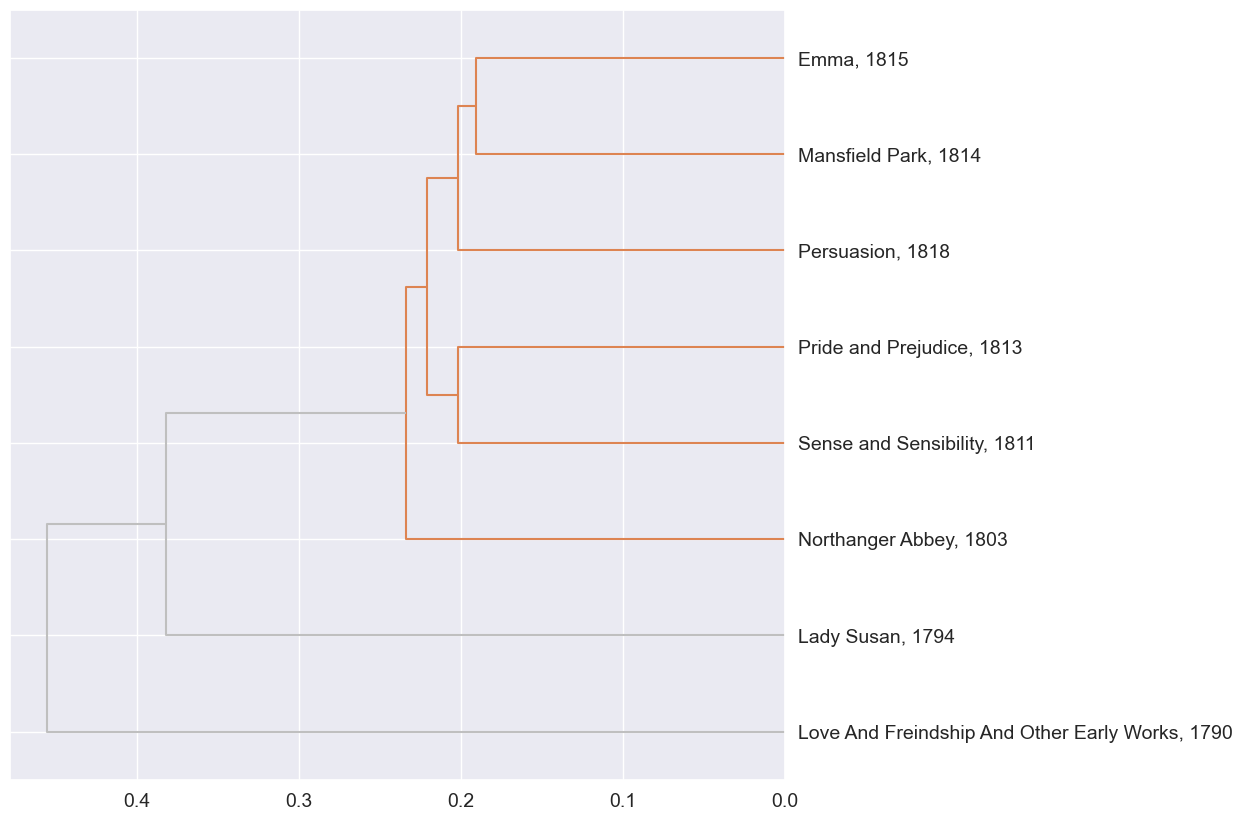

In [28]:
hac(PAIRS.js, linkage_method = "weighted", color_thresh=.3);

# Questions

### Question 1: What are the top 10 nouns by DFIDF, sorted in descending order? Include plural nouns, but don't include proper nouns. 

In [29]:
mean_TFIDF_lim.head(10)

,mean_tfidf,max_pos
term_str,,
tho,0.021181,NN
letter,0.020141,NN
freind,0.019398,NN
was,0.019171,VBD
said,0.018737,VBD
father,0.018017,NN
mother,0.017589,NN
misfortunes,0.016290,NNS
daughter,0.016019,NN


### Question 2: Grouping your TFIDF results by book, and taking the mean TFIDF of all terms per book, what is Austen's most "significant" book? This value is computed from the TFIDF matrix your function returned.

In [30]:
mean_TFIDF_by_book.reset_index().groupby('book_id').mean_tfidf.mean().to_frame('mean_tfidf').sort_values(by='mean_tfidf', ascending=False).reset_index().merge(austen_years, on=['book_id'], how='left').set_index(['book_id', 'label'])

,,mean_tfidf,author
book_id,label,,
1212,"Love And Freindship And Other Early Works, 1790",0.008719,"AUSTEN, JANE"
158,"Emma, 1815",0.008192,"AUSTEN, JANE"
1342,"Pride and Prejudice, 1813",0.008190,"AUSTEN, JANE"
161,"Sense and Sensibility, 1811",0.008018,"AUSTEN, JANE"
946,"Lady Susan, 1794",0.007884,"AUSTEN, JANE"
121,"Northanger Abbey, 1803",0.007730,"AUSTEN, JANE"
105,"Persuasion, 1818",0.007385,"AUSTEN, JANE"
141,"Mansfield Park, 1814",0.007356,"AUSTEN, JANE"


Love And Friendship And Other Early Works

### Question 3: Using the dendograms you generated, which distance measure most clearly distinguishes Austen's two youthful works from her later works? That is, which measure show the greatest separation between the first two work and the rest? Note that the two youthful works were published before 1800.

Cityblock

<Figure size 640x480 with 0 Axes>

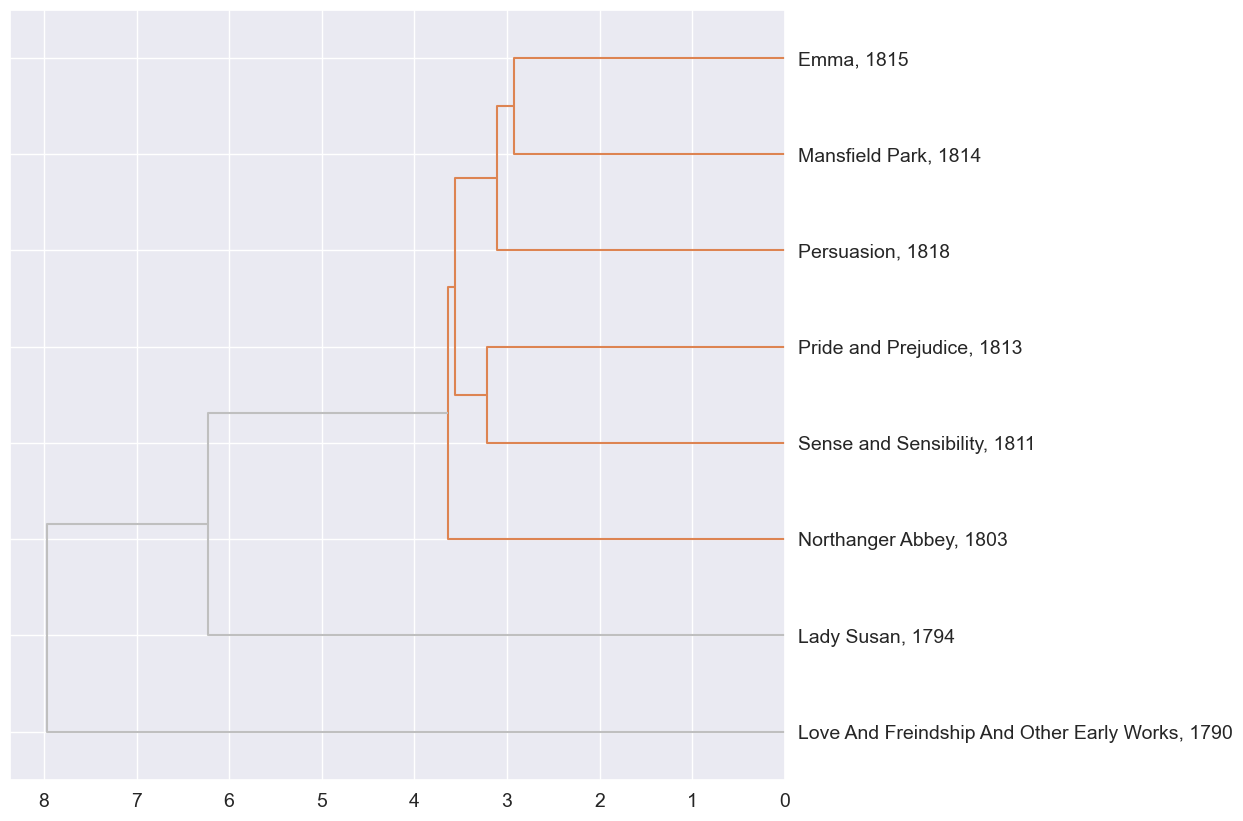

In [31]:
hac(PAIRS.cityblock, linkage_method = "weighted", color_thresh=4);

### Question 4: Do any of the distance measures produce dendrograms with works sorted in the exact order of their publication years? 

Jensenshannon gets close

<Figure size 640x480 with 0 Axes>

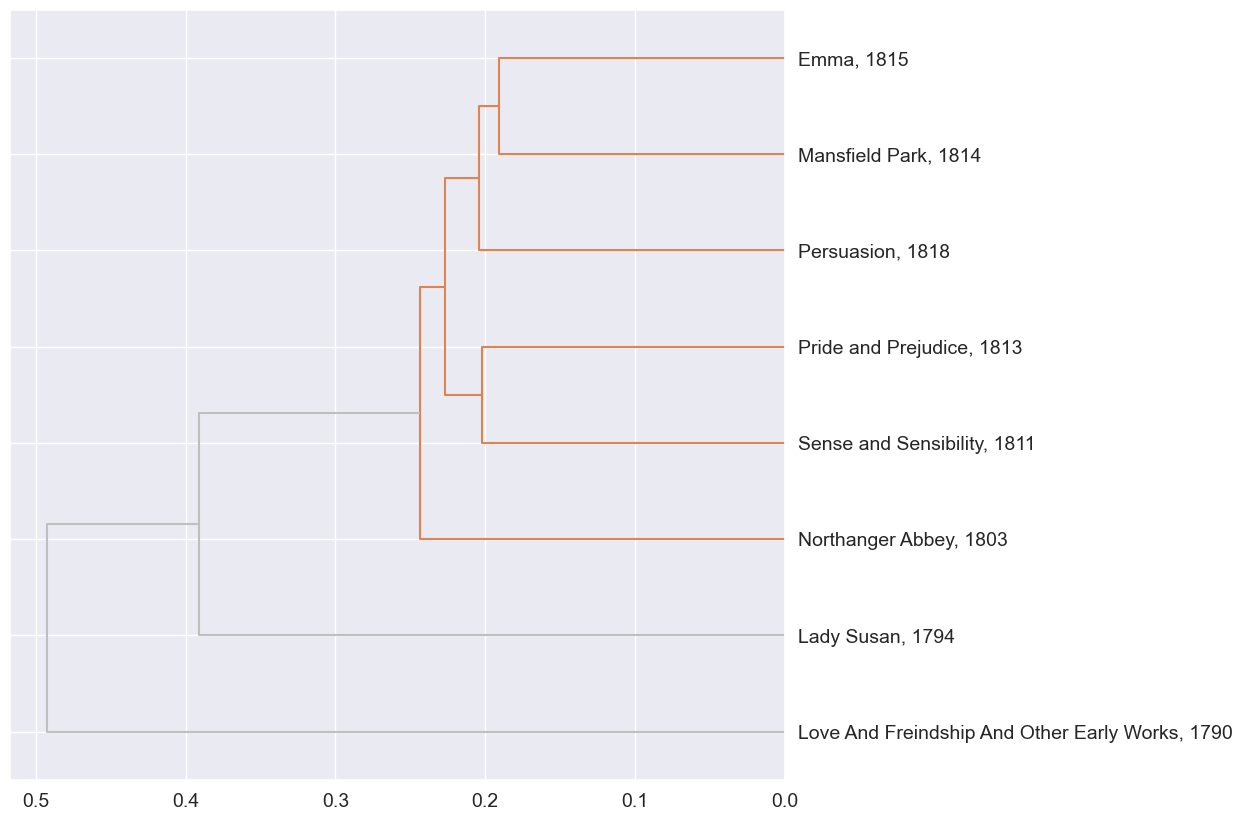

In [32]:
hac(PAIRS.js, color_thresh=.3);

### Question 5: Some literary critics believe that Northanger Abbey is, among Austen's mature works, the one that most resembles her juvenalia, i.e. her two works written as a young adult. Which distance measure dendrograms appear to corroborate this thesis? In other words, do any of them show that Northanger Abbey is closer to her juvenalia than the her other adult works?

Jensenshannon, cityblock, and euclidean put Northanger Abbey closest to the juvenalia.